In [384]:
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tqdm.notebook import tqdm
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import numpy.random as npr
import os, time, gc, random
import glob
import PIL
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Layer

In [385]:
# blocks used in GAN

def minibatchStd(inputs):
    inputs = tf.transpose(inputs, (0, 3, 1, 2)) # NHWC -> NCHW
    group_size = tf.minimum(4, tf.shape(inputs)[0])             # Minibatch must be divisible by (or smaller than) group_size.
    s = inputs.shape                                             # [NCHW]  Input shape.
    y = tf.reshape(inputs, [group_size, -1, 1, s[1], s[2], s[3]])   # [GMncHW] Split minibatch into M groups of size G. Split channels into n channel groups c.
    y -= tf.reduce_mean(y, axis=0, keepdims=True)           # [GMncHW] Subtract mean over group.
    y = tf.reduce_mean(tf.square(y), axis=0)                # [MncHW]  Calc variance over group.
    y = tf.sqrt(y + eps)                                    # [MncHW]  Calc stddev over group.
    y = tf.reduce_mean(y, axis=[2,3,4], keepdims=True)      # [Mn111]  Take average over fmaps and pixels.
    y = tf.reduce_mean(y, axis=[2])                         # [Mn11] Split channels into c channel groups
    y = tf.tile(y, [group_size, 1, s[2], s[3]])             # [NnHW]  Replicate over group and pixels.
    y = tf.concat([inputs, y], axis=1)                        # [NCHW]  Append as new fmap.
    y = tf.transpose(y, (0, 2, 3, 1)) # NCHW -> NHWC
    return y

class DiffUS(tf.keras.layers.Layer):
    def __init__(self):
        return super().__init__()
    
    def call(self, inputs):
        _N, H, W, C = inputs.shape.as_list()
        x = K.reshape(inputs, (-1, H, 1, W, 1, C))
        x = tf.tile(x, (1, 1, 2, 1, 2, 1))
        used = K.reshape(x, (-1, H * 2, W * 2, C))
        return used

def crop_to_fit(x):
    noise, img = x
    height = img.shape[1]
    width = img.shape[2]
    
    return noise[:, :height, :width, :]

ndist = tf.random_normal_initializer(0, 1)
zeros = tf.zeros_initializer()
ones = tf.ones_initializer()

class FCE(Dense): # fully connected equalized
    def __init__(self, units, kernel_initializer=ndist, bias_initializer=zeros, lrelu=True, *args, **kwargs):
        super().__init__(units, *args, **kwargs)
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.lrelu = lrelu
        self.scale = 1

    def build(self, input_shape):
        super().build(input_shape)
        #print('fce', input_shape)
        n = input_shape[-1] # input_shape = (None, features_in) or (None, dimY, dimX, features_in)
        if self.lrelu:
            self.scale = np.sqrt((1 / 0.6) / n) # he but not really, 1 / 0.6 since lrelu(0.2) makes scales variance to 0.6 (0.2 if neg, 1 if pos, div by 2) and you want them to be 1
        else:
            self.scale = np.sqrt(1 / n)

    def call(self, inputs):
        output = K.dot(inputs, self.kernel * self.scale)
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not tf.keras.activations.linear:
            output = self.activation(output)
        elif self.lrelu:
            output = LeakyReLU(alpha=0.2)(output)
        return output

    def get_config(self):
        config = super().get_config()
        config.update({
            'kInit': self.kernel_initializer,
            'bInit': self.bias_initializer,
            'scale': self.scale,
            'useLReLU': self.lrelu,
                      })
        return config

class CVE(Conv2D):
    def __init__(self, units, kernel_size=3, kernel_initializer=ndist, bias_initializer=zeros, padding='same', lrelu=True, *args, **kwargs):
        super().__init__(units, kernel_size, *args, **kwargs)
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.padding = padding
        self.lrelu = lrelu
        self.scale = 1

    def build(self, input_shape):
        super().build(input_shape)
        #print('cve', self.kernel.shape)
        n = np.prod(self.kernel.shape[:-1]) # self.kernel.shape = (kernel_x, kernel_y, features_in, features_out)
        if self.lrelu: # he
            self.scale = np.sqrt((1 / 0.6) / n)
        else:
            self.scale = np.sqrt(1 / n)


    def call(self, inputs):
        output = K.conv2d(inputs, self.kernel * self.scale, padding=self.padding)
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not tf.keras.activations.linear:
            output = self.activation(output)
        elif self.lrelu:
            output = LeakyReLU(alpha=0.2)(output)
        return output

    def get_config(self):
        config = super().get_config()
        config.update({
            'kInit': self.kernel_initializer,
            'bInit': self.bias_initializer,
            'padding': self.padding,
            'scale': self.scale,
            'useLReLU': self.lrelu,
                      })
        return config

class ConvMod(Layer):
    def __init__(self, nf, x, w, kSize=3, demod=True):
        super().__init__()
        self.nf = nf
        self.kSize = kSize
        self.xShape = x.shape
        self.wShape = w.shape
        self.scale = FCE(self.xShape[-1], bias_initializer=ones, lrelu=False)
        self.conv = CVE(nf, kSize, lrelu=demod)
        self.conv(x) # create kernel without doing it in build method so h5py doesn't go sicko mode
        self.demod = demod

    def build(self, input_shape): # input_shape: [TensorShape([None, 4, 4, 256]), TensorShape([None, 256]), TensorShape([None, 4, 4, 1])]
        super().build(input_shape)

    def call(self, inputs):
        x, w = inputs

        x = tf.transpose(x, (0, 3, 1, 2)) # NHWC -> NCHW
        weight = self.conv.kernel[np.newaxis] * self.conv.scale # kkio -> 1kkio (1, kernel_size, kernel_size, input_features, output_features)

        scale = self.scale(w)
        scale = scale[:, np.newaxis, np.newaxis, :, np.newaxis] # Bs -> B, 1, 1, s, 1 (s - scaling factor)

        wp = weight * scale # 1kkio * B11s1 -> Bkk(s*i)o
        wpp = wp

        if self.demod:
            wStd = tf.math.rsqrt(tf.reduce_sum(tf.math.square(wp), axis=[1,2,3]) + 1e-8) # Bkkio -> Bo
            wpp = wp * wStd[:, np.newaxis, np.newaxis, np.newaxis, :] # [BkkIO] Scale output feature maps.

        x = tf.reshape(x, (1, -1, x.shape[2], x.shape[3])) # N, C, H, W -> 1, (N*C), H, W

        # B, k, k, i, o -> k, k, i, B, o -> k, k, i, (B*o)
        wpp = tf.reshape(tf.transpose(wpp, [1, 2, 3, 0, 4]), [wpp.shape[1], wpp.shape[2], wpp.shape[3], -1])

        x = tf.nn.conv2d(x, wpp, padding='SAME', data_format='NCHW', strides=[1, 1, 1, 1]) # grouped conv
        x = tf.reshape(x, (-1, self.nf, x.shape[2], x.shape[3])) # 1, (N*C), H, W -> N, C, H, W
        x = tf.transpose(x, (0, 2, 3, 1)) # NCHW -> NHWC
        x = K.bias_add(x, self.conv.bias)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            'num_filters': self.nf,
            'kernel_size': self.kSize,
            'xShape': self.xShape,
            'wShape': self.wShape,
            'demodulated': self.demod
                      })
        return config

TimeIt

In [386]:
# custom class to see how long tasks take
class timeIt:
    def __init__(self, description):
        self.start = time.time()
        self.description = description
        self.running = True
    
    def new(self, description, verbose=True):
        self.start = time.time()
        self.description = description
        
        duration = time.time() - startTime
        if verbose:
            print('{}; {:.4f} seconds to complete'.format(self.description, duration))
        
        return duration
    
    def close(self, verbose=True):
        duration = time.time() - self.start
        if verbose:
            print('{}; {:.4f} seconds to complete'.format(self.description, duration))
            
        self.start = None
        self.description = None
        self.running = False
        return duration

sess = timeIt('testing timer')
time.sleep(0.005)
_ = sess.close(verbose=True)

testing timer; 0.0052 seconds to complete


Hyperparameters

In [387]:
# reals - numpy array of the training images; ds - batched TF dataset given to the GPU
datasetPath = '../data/d2/*.png'
reals, ds = None, None
gc.collect()

batchSize = 16
m = 2000 # amount of images stored in RAM (reduce if low RAM, increase if high RAM)
m = min(m, int(len(glob.glob(datasetPath))))

m = batchSize * (m // batchSize)
imgSize = 256# size of images in pixels
zdim = imgSize # number of elements in a latent vector
p = 0.0 # probability of data augmentation
n = 4 # number of minibatches before p is changed
numImgsStep = 5e5 # number of images needed to change p from 0 -> 1 or 1 -> 0
pStep = n * batchSize / numImgsStep # how much p increases/decreases per n minibatches
eps = 1e-8 # epsilon, small number used to prevent NaN errors
pplEMA = 0.0 # exponential moving average for average PPL for PPL reg.
depth=8


Load data

In [388]:
AUTO = tf.data.experimental.AUTOTUNE


'''
goes into datasetPath, chooses and stores image data from random files (repeats allowed)
into a np array, converts the array into the TF dataset

Args:
others - random indices for files to choose to train the GAN on
verbose - determines whether duration to complete is printed out or not
'''
def loadData(others=None, verbose=True):
    global reals, ds, m
    sess = timeIt('Loading data')
    reals, ds = None, None
    gc.collect()
    files = glob.glob(datasetPath)
    
    reals = np.zeros((len(files), imgSize, imgSize, 3))
    for i in range(len(files)):
        strI = str(files[i])
        img1=PIL.Image.open(strI).convert("RGB")
        if(img1.size[0]>=img1.size[1]):
            ratio=imgSize/img1.size[0]
        else:
            ratio=imgSize/img1.size[1]
        width=ratio*img1.size[0]
        height=ratio*img1.size[1]
        height_padding_size=int((imgSize-height)/2)
        width_padding_size=int((imgSize-width)/2)
        img1=np.array(img1.resize((int(width),int(height))))
        reals[i,height_padding_size:-height_padding_size,:] = img1
        del img1
    
    reals = reals[:m].astype(np.float32)/127.5-1.0

    assert reals.shape[0] % batchSize == 0
    assert type(reals) == np.ndarray
    ds = (tf.data.Dataset.from_tensor_slices(reals).shuffle(3000).batch(batchSize))
    ds = ds.prefetch(AUTO)
    gc.collect()
    sess.close(verbose=verbose)
    
def aug(imgs, p):
    augImgs = imgs
    def augCond(x):
        randInds = tf.random.uniform((batchSize,))
        trueCond = tf.cast(randInds < p, tf.float32) # using tf.cast to turn booleans into ones and zeros
        falseCond = tf.cast(randInds >= p, tf.float32)
        auged = x * tf.reshape(trueCond, (batchSize, 1, 1, 1)) + augImgs * tf.reshape(falseCond, (batchSize, 1, 1, 1))
        return auged
    
    height = tf.random.uniform((), minval=0.5, maxval=1)
    width = tf.random.uniform((), minval=0.5, maxval=1)
    boxLite = tf.random.uniform((batchSize, 2), maxval=(1-height, 1-width))
    boxes = tf.concat([boxLite, tf.transpose(boxLite[:, 0][np.newaxis]) + height, tf.transpose(boxLite[:, 1][np.newaxis]) + width], axis=1)
    boxLiteIso = tf.random.uniform((batchSize, 1), maxval=1-height)
    boxIso = tf.concat([boxLite, tf.transpose(boxLiteIso[:, 0][np.newaxis]) + height, tf.transpose(boxLiteIso[:, 0][np.newaxis]) + height], axis=1)
    rot90s = np.pi * 90 * tf.cast(tf.random.uniform((batchSize,), minval=0, maxval=4, dtype=tf.int32), tf.float32) / 180
    augImgs = augCond(tf.image.random_brightness(augImgs, max_delta=0.25))
    augImgs = augCond(tf.image.crop_and_resize(augImgs, boxIso, tf.range(batchSize), (imgSize, imgSize), extrapolation_value=1))
    augImgs = augCond(tf.image.crop_and_resize(augImgs, boxes, tf.range(batchSize), (imgSize, imgSize), extrapolation_value=1))
    augImgs = augCond(tfa.image.rotate(augImgs, rot90s))
    augImgs = augCond(tfa.image.rotate(augImgs, tf.random.uniform((batchSize,), minval=-np.pi/6, maxval=np.pi/6)))
    augImgs = augCond(tfa.image.translate(augImgs, tf.random.normal((batchSize, 2), 0, imgSize // 10)))
    return augImgs
loadData()

Loading data; 41.1925 seconds to complete


Layers

In [389]:
'''
Generator style block.
Args:
accum - accumulated output from the input/output skips
x - the non-RGB image input
w - the style (output of the mapping function with input of the latent vector)
noiseInp - normally distributed noise
filters - number of channels/feature maps the output of the style block will have
us - whether or not to upsample the images
'''
def gblock(accum, x, w, noiseInp, filters, us=True):
    if us:
        x = DiffUS()(x) # using custom upsampling function since other upsampling methods didn't provide gradients of their gradients
        accum = DiffUS()(accum)
    
    for i in range(2):
        x = ConvMod(filters, x, w)([x, w])
        noise = Lambda(crop_to_fit)([noiseInp, x]) # crop noises so it can be added with x
        noise = FCE(filters, kernel_initializer=zeros, use_bias=False, lrelu=False)(noise) #scale noises
        x = Add()([x, noise])
        x = LeakyReLU(alpha=0.2)(x)
    
    trgb = ConvMod(3, x, w, 1, demod=False)([x, w]) # toRGB 1x1 convolution
    accum = Add()([accum, trgb]) * np.sqrt(1 / 2) # the sqrt(1/2) not included in original StyleGAN2 but i didn't see why not
        
    return accum, x

# Discriminator block.
def dblock(x, filters, maxFilters=256):
    frgb = CVE(min(2 * filters, maxFilters), 1, lrelu=False, use_bias=False)(x)
    
    x = CVE(filters)(x)
    x = CVE(min(2 * filters, maxFilters))(x)
        
    frgb = AveragePooling2D()(frgb)
    x = AveragePooling2D()(x)
    x = Add()([x, frgb])
    
    return x

Build models

In [390]:
nBlocks = int(np.log2(imgSize / 4)) # number of upsampled style blocks

# mapper architecture
def ztow(nlayers=8):
    z = Input((zdim,))
    w = z
    if nlayers > 0:
        w = LayerNormalization()(w)
    for i in range(max(nlayers-1, 0)):
        w = FCE(zdim)(w)
    return Model(z, w, name='mapping')

# generator architecture
def genGen():
    ws = [Input((zdim,), name='w{}'.format(i)) for i in range(nBlocks+1)]
    noiseInp = Input((imgSize, imgSize, 1), name='noiseInp')

    x = Dense(1)(ws[0]); x = Lambda(lambda x: x * 0 + 1)(x)
    x = FCE(4*4*zdim, lrelu=False, use_bias=False)(x)
    x = Reshape((4, 4, zdim))(x)
    
    layerFilters = (512,256, 256, 128, 64, 32)
    
    x = ConvMod(layerFilters[0], x, ws[0])([x, ws[0]])
    noise = Lambda(crop_to_fit)([noiseInp, x])
    noise = FCE(layerFilters[0], kernel_initializer=zeros, use_bias=False, lrelu=False)(noise)
    x = Add()([x, noise])
    x = LeakyReLU(alpha=0.2)(x)
    accum = ConvMod(3, x, ws[0], 1, demod=False)([x, ws[0]])
    
    for idx, f in enumerate(layerFilters):
        accum, x = gblock(accum, x, ws[idx+1], noiseInp, f)
        
    out = CVE(3, 1, lrelu=False)(accum)
    return Model([*ws, noiseInp], out, name='generator')
      
# discriminator architecture  
def genDisc():
    inp = Input((imgSize, imgSize, 3)); x = inp

    layerFilters = (32, 64, 128, 256, 256, 512)
    
    x = CVE(layerFilters[0], 1)(x)
    for fi, f in enumerate(layerFilters):
        x = dblock(x, f, maxFilters=layerFilters[-1])
    
    x = Lambda(minibatchStd)(x)
    x = CVE(layerFilters[-1])(x)
    x = Flatten()(x)
    x = FCE(layerFilters[-1])(x)
    out = FCE(1, lrelu=False)(x)

    return Model(inp, out, name='discriminator')

In [391]:
modelPath = '../model/StyleGan/embryo_512/'
fids, gcosts, dcosts = [], [], []
pplNorms = []
gpcosts = []
ps, rts = [], []


mapper = ztow(nlayers=depth)
generator = genGen()
discriminator = genDisc()
inception = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(imgSize, imgSize, 3)) # for FID score


Optimizers and losses

In [392]:
lr = 2e-3 * batchSize / 32
mapOpt = Adam(lr / 100, epsilon=1e-8)
genOpt = Adam(lr, 0, 0.9, epsilon=1e-8)
discOpt = Adam(lr, 0, 0.9, epsilon=1e-8)

In [393]:
def rt(truePreds): # overfitting metric
    return tf.reduce_mean(tf.sign(truePreds))

def dra(obsPreds, basePreds): # observe/baseline predictions (representing fake/true data)
    meanBase = K.mean(basePreds)
    return tf.nn.sigmoid(obsPreds - meanBase)

def discLoss(truePreds, fakePreds, epsilon=eps):
    trueLoss = K.mean(tf.nn.softplus(-truePreds)) # -log(sigmoid(real_scores_out))
    fakeLoss = K.mean(tf.nn.softplus(fakePreds)) # -log(1-sigmoid(fake_scores_out))
    classLoss = trueLoss + fakeLoss
    return classLoss

def genLoss(fakePreds, epsilon=eps):
    classLoss = K.mean(tf.nn.softplus(-fakePreds))
    return classLoss

Regularizers

In [394]:
# path length reg.
@tf.function
def pplReg(a=0.0):
    pplbatchSize = batchSize // 2
    y = tf.random.normal((pplbatchSize, imgSize, imgSize, 3))
    noise = tf.random.uniform((pplbatchSize, imgSize, imgSize, 1))
    z = tf.random.normal((pplbatchSize, zdim))
    
    w = mapper(z, training=True)
    ws = [w for _ in range(nBlocks+1)]
    preds = generator([*ws, noise], training=True)
    jacLite = tf.math.reduce_sum(preds * y)
    
    jac = tf.gradients(jacLite, w)[0]
    norm = tf.norm(jac)
    return K.mean(tf.square(norm - tf.cast(a, tf.float32))), norm

FID function

In [395]:
from scipy.linalg import sqrtm

allRealFeatures = None

# turn TF tensor outputs into numpy array outputs
def toNp(*args):
    ret = []
    for i in args:
        meanVal = i
        try:
            meanVal = i.numpy()
        except:
            pass
        ret.append(meanVal)
    return ret

def calculate_fid():
    global allRealFeatures
    
    def crunch(batch, bs=64):
        z1, z2 = npr.randn(2, bs, zdim)
        noise = npr.randn(bs, imgSize, imgSize, 1)
        w1 = mapper(z1, training=False)
        w2 = mapper(z2, training=False)
        ws = [w1 for _ in range(3)] + [w2 for _ in range(4)]
        fakes = generator([*ws, noise], training=False)
        fakeFeatures = inception(fakes/2+0.5, training=False)
        realFeatures = inception(batch/2+0.5, training=False)
        return fakeFeatures.numpy(), realFeatures.numpy()
    def crunchLite(batch, bs=64):
        z1, z2 = npr.randn(2, bs, zdim)
        noise = npr.randn(bs, imgSize, imgSize, 1)
        w1 = mapper(z1, training=False)
        w2 = mapper(z2, training=False)
        ws = [w1 for _ in range(3)] + [w2 for _ in range(4)]
        fakes = generator([*ws, noise], training=False)
        fakeFeatures = inception(fakes/2+0.5, training=False)
        return fakeFeatures.numpy(), -1
    
    K.clear_session()
    bs = 16
    expandM = bs * (m//bs)
    crunchFunc = crunchLite
    if allRealFeatures is None:
        crunchFunc = crunch
        allRealFeatures = np.zeros((expandM, 2048))
        
    allFakeFeatures = np.zeros((expandM, 2048))
    for batchS in tqdm(range(0, expandM, bs)):
        batch = reals[batchS: batchS + bs]
        fakeFeatures, realFeatures = crunchFunc(batch, bs=bs)
        allFakeFeatures[batchS: batchS + bs] = fakeFeatures
        
        if crunchFunc == crunch:
            allRealFeatures[batchS: batchS + bs] = realFeatures
        
    # calculate mean and covariance statistics
    fakeMean, fakeStd = np.mean(allFakeFeatures, axis=0), np.cov(allFakeFeatures, rowvar=False)
    realMean, realStd = np.mean(allRealFeatures, axis=0), np.cov(allRealFeatures, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((fakeMean - realMean) ** 2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(np.dot(fakeStd, realStd))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(fakeStd + realStd - 2.0 * covmean)
    K.clear_session()
    return fid

Step function

In [396]:
'''
One training step for the GAN.
Args:
batch - input batch of real images
p - probability of augmenting image
pplEMA - skip PPL reg. if it is -1, else use the value for regularization
useGP - skip R1 gradient penalty if it is -1
'''
@tf.function
def trainStep(batch, p, pplEMA=-tf.ones(()), useGP=-tf.ones(())):
    def genImgs():
        z1 = tf.random.normal([batchSize, zdim])
        z2 = tf.random.normal([batchSize, zdim])
        noise = tf.random.normal([batchSize, imgSize, imgSize, 1])

        w1 = z1; w2 = z2
        w1 = mapper(z1, training=True)
        w2 = tf.cond(tf.random.uniform(()) < 0.9, lambda: mapper(z2, training=True), lambda: w1)
        splitInd = npr.randint(nBlocks+1)
        ws = [w1 for _ in range(splitInd)] + [w2 for _ in range(nBlocks+1-splitInd)]
        fakes = generator([*ws, noise], training=True)
        return fakes
    
    fakes = genImgs()
    augBatch = aug(batch, p)
    augFakes = aug(fakes, p)
    truePreds = discriminator(augBatch, training=True)
    fakePreds = discriminator(augFakes, training=True)

    gpWeight = 16 * 10 / 2
    gploss = tf.cond(useGP >= 0, lambda: gpWeight * K.mean((tf.reduce_sum(tf.square(tf.gradients(truePreds, [augBatch])[0]), axis=[1,2,3]))), lambda: 0.0)

    dloss = discLoss(truePreds, fakePreds) + gploss
    rtBatch = rt(truePreds)
    
    fakes = genImgs()
    augFakes = aug(fakes, p)
    fakePreds = discriminator(augFakes, training=True)

    pplWeight = 8 * 2 / (imgSize * imgSize * (nBlocks + 1))
    pplLoss, pplNorm = tf.cond(pplEMA >= 0, lambda: pplReg(pplEMA), lambda: (0.0, 0.0))
    pplLoss = pplWeight * pplLoss
    gloss = genLoss(fakePreds) + pplLoss
    
    dGrad = tf.gradients(dloss, discriminator.trainable_variables)
    discOpt.apply_gradients(zip(dGrad, discriminator.trainable_variables))

    gGrad = tf.gradients(gloss, generator.trainable_variables)
    genOpt.apply_gradients(zip(gGrad, generator.trainable_variables))
    
    mGrad = tf.gradients(gloss, mapper.trainable_variables)
    mapOpt.apply_gradients(zip(mGrad, mapper.trainable_variables))
    
    return dloss, gploss, gloss, rtBatch, pplLoss, pplNorm

Gradient visualization function

In [397]:
def retGrads():
    z1 = tf.random.normal([1, zdim])
    z2 = tf.random.normal([1, zdim])
    noise = tf.random.normal([1, imgSize, imgSize, 1])
    randImg = tf.convert_to_tensor(reals[npr.randint(0, reals.shape[0])][np.newaxis])

    with tf.GradientTape() as tapeReal, tf.GradientTape() as tapeFake:
        w1 = z1; w2 = z2
        w1 = mapper(z1, training=False)
        w2 = mapper(z2, training=False)
        ws = [w1 for _ in range(3)] + [w2 for _ in range(4)]
        tapeReal.watch(randImg)
        fakes = generator([*ws, noise], training=False)
        tapeFake.watch(fakes)
        truePreds = discriminator(randImg, training=False)
        fakePreds = discriminator(fakes, training=False)
        dloss = discLoss(truePreds, fakePreds)

    realGrad = tapeReal.gradient(dloss, randImg)[0]
    fakeGrad = tapeFake.gradient(dloss, fakes)[0]
    realNorm = tf.norm(realGrad)
    fakeNorm = tf.norm(fakeGrad)
    return realGrad.numpy(), fakeGrad.numpy(), realNorm.numpy(), fakeNorm.numpy(), randImg[0].numpy(), fakes[0].numpy(), truePreds.numpy(), fakePreds.numpy()

Train functions

In [398]:
def train(epochs=None, steps=None, n=4):
    global p, pplNorms, pplEMA
    gc.collect()
    rtBatches = 0
    
    if epochs != None:
        for i in range(epochs):
            gc.collect()
            dcost, gpcost, gcost = 0, 0, 0
            pplSum = 0
            rtSum, pplCost = 0, 0
            batchNum = 0
            for batch in ds:
                pTensor = tf.convert_to_tensor(p, dtype=tf.float32)
                batch = reals[npr.randint(0, m, (batchSize,))]
                if batchNum % 16 == 0:
                    vals = toNp(*trainStep(batch, pTensor, tf.convert_to_tensor(pplEMA), useGP=tf.ones(())))
                elif batchNum % 8 == 0:
                    vals = toNp(*trainStep(batch, pTensor, tf.convert_to_tensor(pplEMA)))
                else:
                    vals = toNp(*trainStep(batch, pTensor))
                dloss, gploss, gloss, rtBatch, pplLoss, pplNorm = vals

                if pplNorm != 0:
                    pplEMA = 0.01 * pplNorm + 0.99 * pplEMA
                
                rtBatches += rtBatch
                if batchNum % n == 0:
                    p += pStep * np.sign(rtBatches/n - 0.6)
                    p = round(min(max(p, 0), 1), 6) % 0.8
                    rtBatches = 0
                batchNum += 1
                dcost += dloss; gpcost += gploss; gcost += gloss; rtSum += rtBatch; pplCost += pplLoss; pplSum += pplNorm
            
            dcosts.append(dcost)
            gcosts.append(gcost)
            gpcosts.append(gpcost)
            pplNorms.append(round(pplSum / batchNum, 4))
            ps.append(p)
            rts.append(rtBatch)
            print('Epoch: {} | D Cost: {} | GP Cost: {} | G Cost: {}'.format(i, dcost, gpcost, gcost), end = ' | ')
            print('P(aug): {} | Rt: {} | PPL Norm: {} | PPL Loss: {}'.format(p, round(rtSum / batchNum, 4), round(pplSum / batchNum, 4), round(pplCost, 4)))

Display function

In [399]:
rows, cols = 1, 4

'''
Display generated images as well as a summary of model metrics.
Args:
z1/z2 - latent input vector 1/2
noise - noise input
verbose - 5-element list saying which metrics to calculate and print out
verbose[0] - FID score
verbose[1] - D(G(z)) - discriminator predictions on generated images
verbose[2] - D(x) - discriminator predictions on real images
verbose[3/4] - D/G Loss
verbose=True/1: print everything
verbose=False/0: print nothing
'''

def display(z1, z2, noise, verbose=True):
    gc.collect()
    fig = plt.figure(figsize=(30, 5))
    axes = fig.subplots(rows, cols)
    
    z1[0] = constZ; z2[0] = constZ; noise[0] = constNoise
    assert z1.shape == (rows * cols, zdim)
    assert z2.shape == (rows * cols, zdim)
    assert noise.shape == (rows * cols, imgSize, imgSize, 1)
        
    randInds = npr.randint(0, reals.shape[0], (rows*cols,))
    
    w1 = z1; w2 = z2
    w1 = mapper(z1, training=False)
    w2 = mapper(z2, training=False)
    ws = [w1 for _ in range(3)] + [w2 for _ in range(4)]
    preds = generator([*ws, noise], training=False)
    df = discriminator(preds, training=False)
    dr = discriminator(reals[randInds], training=False)
    if type(verbose) == type(True):
        verbose = [verbose for i in range(5)]
    if type(verbose) == int:
        if verbose == 0:
            verbose = [False for i in range(5)]
        elif verbose == 1:
            verbose = [False, False, False, True, True]
        elif verbose == 2:
            verbose = [False, True, True, True, True]
        elif verbose == 3:
            verbose = [True for i in range(5)]
            
    if verbose[1]:
        print('D(G(z)) (lower = better disc):', np.mean(df))
    if verbose[2]:
        print('D(x) (higher = better disc):', np.mean(dr))
    if verbose[3]:
        print('D Loss:', discLoss(dr, df))
    if verbose[4]:
        print('G Loss:', genLoss(df))
    
    for i in range(rows):
        for j in range(cols):
            axes[j].imshow(preds[i*cols + j] / 2 + 0.5)

    plt.show()
    
    if verbose[0]:
        fid = round(calculate_fid(), 4)
        print('FID:', fid)
        fids.append(fid)
    return preds

Save model function

In [400]:
'''
Save current state of model, overwriting past state of model on disk.
Args:
askInp - require user to place input before saving models - protects user from accidentally overwriting models with a collapsed model
'''
def save_models(askInp=True):
    if askInp:
        input()
    
    
    generator.save_weights(modelPath+'genWeights.h5')
    discriminator.save_weights(modelPath+'discWeights.h5')
    mapper.save_weights(modelPath+'mapWeights.h5')

Train GAN

D(G(z)) (lower = better disc): 0.1275286
D(x) (higher = better disc): -0.3144711
D Loss: tf.Tensor(1.623071, shape=(), dtype=float32)
G Loss: tf.Tensor(0.6319716, shape=(), dtype=float32)


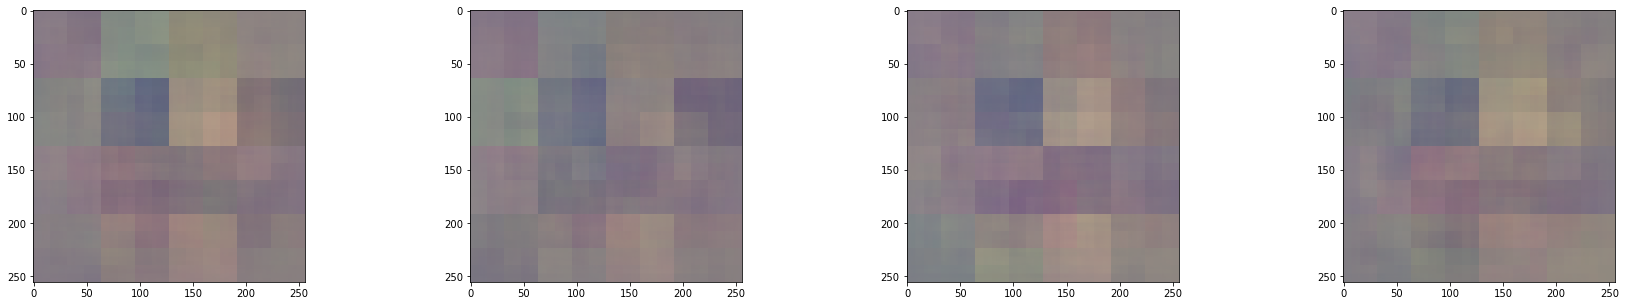

  0%|          | 0/108 [00:00<?, ?it/s]

FID: 435.6025
Epoch: 0 | D Cost: 104.41623251885176 | GP Cost: 2.8213712126016617 | G Cost: 238.2798806038918 | P(aug): 0.001024 | Rt: 0.7303 | PPL Norm: 34.1173 | PPL Loss: 33.0011
Epoch: 1 | D Cost: 102.99111621081829 | GP Cost: 3.41623792052269 | G Cost: 197.60120566934347 | P(aug): 0.000896 | Rt: 0.5579 | PPL Norm: 34.6815 | PPL Loss: 23.7547
Epoch: 2 | D Cost: 95.9214431643486 | GP Cost: 7.850850403308868 | G Cost: 209.0315210474655 | P(aug): 0.00128 | Rt: 0.6285 | PPL Norm: 30.5066 | PPL Loss: 12.904
Epoch: 3 | D Cost: 90.79626449197531 | GP Cost: 11.280771374702454 | G Cost: 216.88656732439995 | P(aug): 0.002176 | Rt: 0.6678 | PPL Norm: 30.2103 | PPL Loss: 9.4815
Epoch: 4 | D Cost: 103.52292641997337 | GP Cost: 13.829688429832458 | G Cost: 188.93445953726768 | P(aug): 0.001792 | Rt: 0.5613 | PPL Norm: 30.1573 | PPL Loss: 6.9806
Epoch: 5 | D Cost: 100.86338320374489 | GP Cost: 14.413772821426392 | G Cost: 184.06796818971634 | P(aug): 0.001152 | Rt: 0.5787 | PPL Norm: 29.9666 | PP

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -2.0213246
D(x) (higher = better disc): 2.1279845
D Loss: tf.Tensor(0.29831004, shape=(), dtype=float32)
G Loss: tf.Tensor(2.18222, shape=(), dtype=float32)


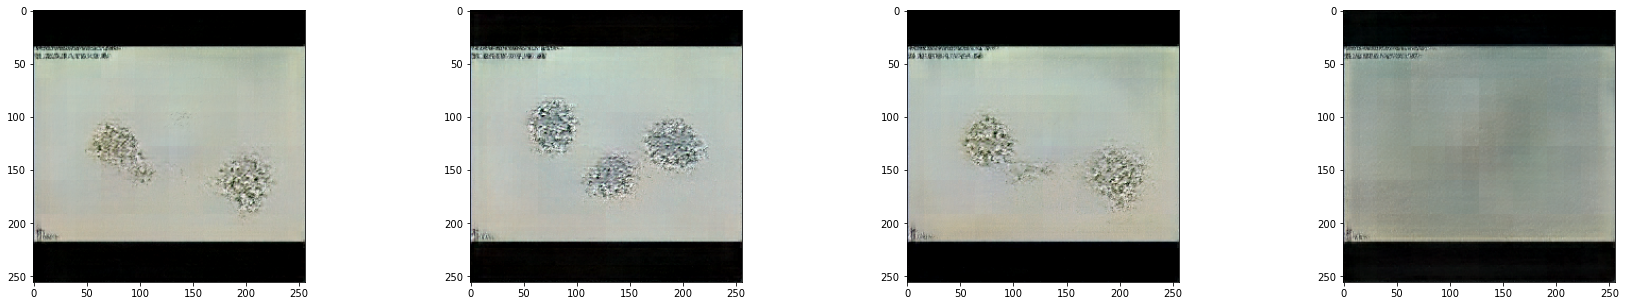

  0%|          | 0/108 [00:00<?, ?it/s]

FID: 268.7298
Epoch: 0 | D Cost: 99.32244536280632 | GP Cost: 18.75799012184143 | G Cost: 170.82490813732147 | P(aug): 0.062592 | Rt: 0.6863 | PPL Norm: 35.3827 | PPL Loss: 2.9663
Epoch: 1 | D Cost: 97.65849593281746 | GP Cost: 17.593671560287476 | G Cost: 167.80694591999054 | P(aug): 0.063232 | Rt: 0.6505 | PPL Norm: 36.9396 | PPL Loss: 1.5176
Epoch: 2 | D Cost: 95.28125631809235 | GP Cost: 17.628100275993347 | G Cost: 174.67566055059433 | P(aug): 0.06464 | Rt: 0.684 | PPL Norm: 40.367 | PPL Loss: 4.83
Epoch: 3 | D Cost: 100.74641045928001 | GP Cost: 19.285056114196777 | G Cost: 166.86903458833694 | P(aug): 0.065536 | Rt: 0.6505 | PPL Norm: 37.0805 | PPL Loss: 2.1319
Epoch: 4 | D Cost: 101.50840473175049 | GP Cost: 18.27652931213379 | G Cost: 167.43764325976372 | P(aug): 0.066688 | Rt: 0.6435 | PPL Norm: 40.0039 | PPL Loss: 4.2288
Epoch: 5 | D Cost: 101.4739761352539 | GP Cost: 19.417556762695312 | G Cost: 163.7662075459957 | P(aug): 0.067584 | Rt: 0.6586 | PPL Norm: 35.6053 | PPL Los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -2.0669432
D(x) (higher = better disc): 1.2202611
D Loss: tf.Tensor(0.41686928, shape=(), dtype=float32)
G Loss: tf.Tensor(2.1884084, shape=(), dtype=float32)


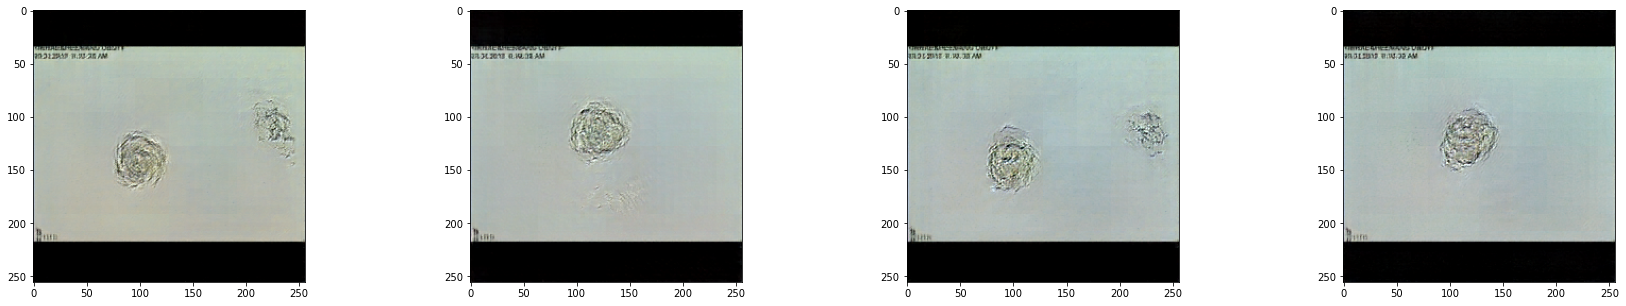

  0%|          | 0/108 [00:00<?, ?it/s]

FID: 211.3721
Epoch: 0 | D Cost: 111.82024389505386 | GP Cost: 15.867172837257385 | G Cost: 143.22638189792633 | P(aug): 0.087424 | Rt: 0.5556 | PPL Norm: 43.3075 | PPL Loss: 4.0663
Epoch: 1 | D Cost: 108.51197576522827 | GP Cost: 14.718981623649597 | G Cost: 141.65914699435234 | P(aug): 0.086784 | Rt: 0.566 | PPL Norm: 47.2992 | PPL Loss: 2.9255
Epoch: 2 | D Cost: 113.6238403916359 | GP Cost: 17.80305552482605 | G Cost: 134.8038954436779 | P(aug): 0.0864 | Rt: 0.5683 | PPL Norm: 43.8362 | PPL Loss: 3.4571
Epoch: 3 | D Cost: 105.13046225905418 | GP Cost: 15.709971308708191 | G Cost: 147.65165930986404 | P(aug): 0.086016 | Rt: 0.5961 | PPL Norm: 45.1898 | PPL Loss: 7.9384
Epoch: 4 | D Cost: 108.36166113615036 | GP Cost: 15.295092701911926 | G Cost: 141.63161104917526 | P(aug): 0.085888 | Rt: 0.5683 | PPL Norm: 51.4399 | PPL Loss: 4.5959
Epoch: 5 | D Cost: 110.04477536678314 | GP Cost: 14.931273460388184 | G Cost: 138.28349936008453 | P(aug): 0.085504 | Rt: 0.5799 | PPL Norm: 48.0671 | P

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): 0.011729866
D(x) (higher = better disc): 2.1929731
D Loss: tf.Tensor(0.88994074, shape=(), dtype=float32)
G Loss: tf.Tensor(0.7156223, shape=(), dtype=float32)


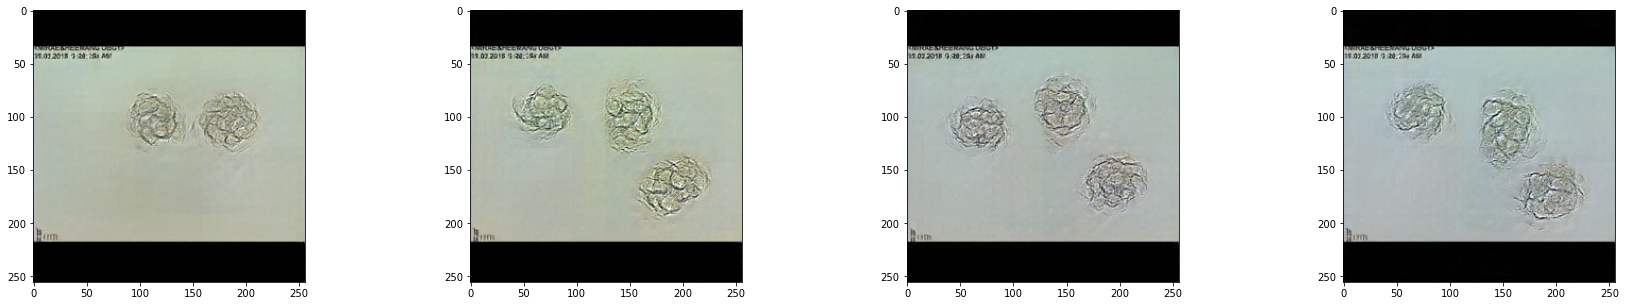

  0%|          | 0/108 [00:00<?, ?it/s]

FID: 151.0518
Epoch: 0 | D Cost: 110.16988921165466 | GP Cost: 19.03263282775879 | G Cost: 141.18545159697533 | P(aug): 0.072064 | Rt: 0.6134 | PPL Norm: 48.7951 | PPL Loss: 3.8836
Epoch: 1 | D Cost: 109.92213189601898 | GP Cost: 19.50360608100891 | G Cost: 138.93330439925194 | P(aug): 0.073216 | Rt: 0.6354 | PPL Norm: 54.4282 | PPL Loss: 3.7547
Epoch: 2 | D Cost: 114.45568662881851 | GP Cost: 17.392966628074646 | G Cost: 135.0125066637993 | P(aug): 0.071552 | Rt: 0.537 | PPL Norm: 52.4295 | PPL Loss: 5.0531
Epoch: 3 | D Cost: 107.71749395132065 | GP Cost: 15.144099712371826 | G Cost: 142.86366519331932 | P(aug): 0.071936 | Rt: 0.6042 | PPL Norm: 47.7192 | PPL Loss: 6.1771
Epoch: 4 | D Cost: 109.9528466463089 | GP Cost: 19.113417387008667 | G Cost: 141.92486518621445 | P(aug): 0.072064 | Rt: 0.5914 | PPL Norm: 54.0969 | PPL Loss: 4.0893
Epoch: 5 | D Cost: 112.45963960886002 | GP Cost: 18.458000421524048 | G Cost: 134.26637223362923 | P(aug): 0.071936 | Rt: 0.5972 | PPL Norm: 51.8511 | 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): 0.18773171
D(x) (higher = better disc): 2.5346537
D Loss: tf.Tensor(0.8924305, shape=(), dtype=float32)
G Loss: tf.Tensor(0.61774516, shape=(), dtype=float32)


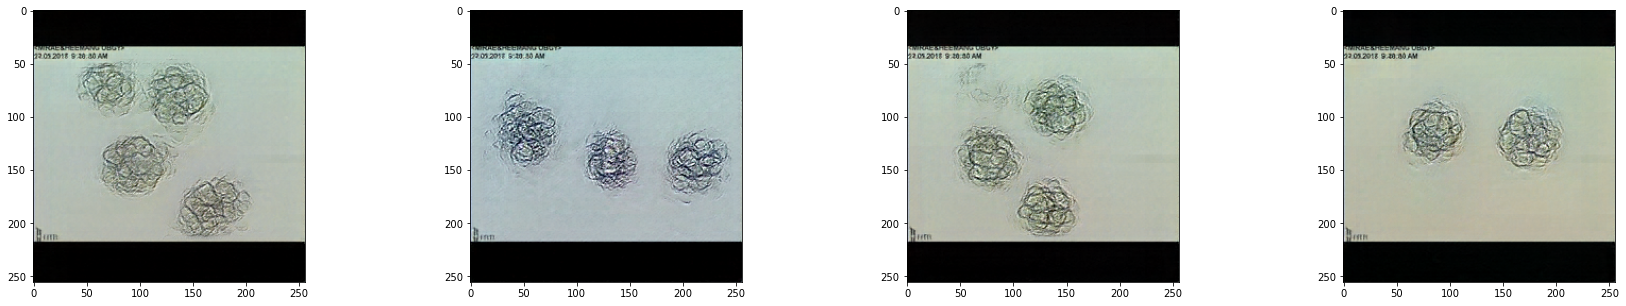

  0%|          | 0/108 [00:00<?, ?it/s]

FID: 115.3024
Epoch: 0 | D Cost: 114.11809837818146 | GP Cost: 18.814486980438232 | G Cost: 130.75041288137436 | P(aug): 0.059008 | Rt: 0.588 | PPL Norm: 54.6298 | PPL Loss: 4.3014
Epoch: 1 | D Cost: 109.7535697221756 | GP Cost: 18.131522178649902 | G Cost: 153.02026689052582 | P(aug): 0.059648 | Rt: 0.6296 | PPL Norm: 58.3041 | PPL Loss: 17.281
Epoch: 2 | D Cost: 105.88453793525696 | GP Cost: 16.64230716228485 | G Cost: 143.2923168540001 | P(aug): 0.059776 | Rt: 0.6215 | PPL Norm: 57.9178 | PPL Loss: 6.173
Epoch: 3 | D Cost: 109.64804482460022 | GP Cost: 19.83075523376465 | G Cost: 153.41798201203346 | P(aug): 0.059648 | Rt: 0.5995 | PPL Norm: 62.3918 | PPL Loss: 17.3087
Epoch: 4 | D Cost: 108.99265265464783 | GP Cost: 18.06729507446289 | G Cost: 139.57445871829987 | P(aug): 0.0608 | Rt: 0.6331 | PPL Norm: 55.4816 | PPL Loss: 6.3278
Epoch: 5 | D Cost: 108.17805916070938 | GP Cost: 19.006276607513428 | G Cost: 149.92661947011948 | P(aug): 0.060928 | Rt: 0.5822 | PPL Norm: 62.658 | PPL 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): 0.47885585
D(x) (higher = better disc): 2.7640707
D Loss: tf.Tensor(1.0354443, shape=(), dtype=float32)
G Loss: tf.Tensor(0.48917815, shape=(), dtype=float32)


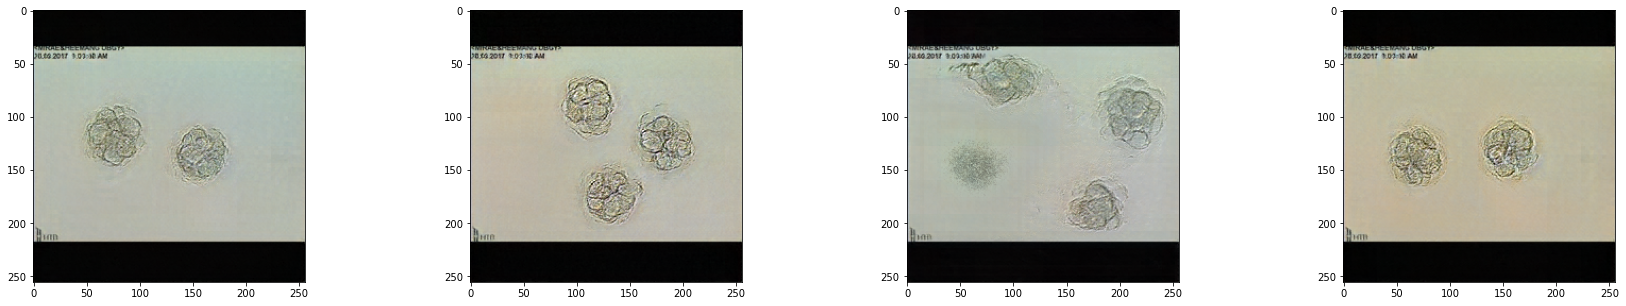

  0%|          | 0/108 [00:00<?, ?it/s]

FID: 82.3094
Epoch: 0 | D Cost: 116.19363045692444 | GP Cost: 21.733541011810303 | G Cost: 126.4319297671318 | P(aug): 0.060544 | Rt: 0.6215 | PPL Norm: 66.4211 | PPL Loss: 5.7141
Epoch: 1 | D Cost: 118.79652124643326 | GP Cost: 19.392826080322266 | G Cost: 123.75892114639282 | P(aug): 0.060928 | Rt: 0.5926 | PPL Norm: 63.51 | PPL Loss: 5.3657
Epoch: 2 | D Cost: 119.0886777639389 | GP Cost: 20.066354990005493 | G Cost: 120.30134126543999 | P(aug): 0.061312 | Rt: 0.581 | PPL Norm: 64.233 | PPL Loss: 1.5565
Epoch: 3 | D Cost: 117.33919179439545 | GP Cost: 20.432279348373413 | G Cost: 125.27461260557175 | P(aug): 0.060416 | Rt: 0.5764 | PPL Norm: 59.7252 | PPL Loss: 6.1854
Epoch: 4 | D Cost: 115.09140986204147 | GP Cost: 20.181342840194702 | G Cost: 127.21081590652466 | P(aug): 0.061056 | Rt: 0.6019 | PPL Norm: 64.4685 | PPL Loss: 4.8705
Epoch: 5 | D Cost: 115.0305153131485 | GP Cost: 18.789496183395386 | G Cost: 123.37071007490158 | P(aug): 0.060928 | Rt: 0.6088 | PPL Norm: 67.2456 | PPL

In [401]:
constZ = npr.randn(zdim,)
constNoise = npr.randn(imgSize, imgSize, 1)
epoch = 0
if type(reals) != np.ndarray or type(ds) == type(None):
        loadData()
while True:
    sess = timeIt('Training')
    display(z1=npr.randn(rows * cols, zdim), z2=npr.randn(rows * cols, zdim), noise=npr.randn(rows * cols, imgSize, imgSize, 1), verbose=True)
    train(epochs=50)
    epoch += 1
    sess.close()
    save_models(askInp=False)
    np.save(os.path.join(modelPath, 'p.npy'), p) # save p value for future training if training on servers with time limits like Paperspace

Visualize gradients

In [ ]:
if type(reals) != np.ndarray or type(ds) == type(None):
    #loadData()
    reals = np.load(os.path.join(datasetPath, 'imgs.npy'))
    m = batchSize * (reals.shape[0] // batchSize)
    reals = reals[:m].astype(np.float32)

    assert reals.shape[0] % batchSize == 0
    assert type(reals) == np.ndarray
    ds = (tf.data.Dataset.from_tensor_slices(tf.cast(reals, tf.float32)).shuffle(3000).batch(batchSize))
    ds = ds.prefetch(AUTO)
    gc.collect()

dGrad, gGrad, dNorm, gNorm, img, fake, truePreds, fakePreds = retGrads()
dGrad = np.sum(dGrad, axis=2)
gGrad = np.sum(gGrad, axis=2)
print('D(x): {} | D(G(z)): {}'.format(truePreds, fakePreds))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
dGrad = (dGrad - np.min(dGrad)) / (np.max(dGrad) - np.min(dGrad) + eps)
gGrad = (gGrad - np.min(gGrad)) / (np.max(gGrad) - np.min(gGrad) + eps)
axes[0][0].imshow(img/2+0.5)
axes[0][1].imshow(fake/2+0.5)
axes[1][0].imshow(dGrad)
axes[1][0].set_title('Real Grad; Norm: {}'.format(round(dNorm, 4)))
axes[1][1].imshow(gGrad)
axes[1][1].set_title('Fake Grad; Norm: {}'.format(round(gNorm, 4)))
plt.show()

Visualize mapping activations

In [ ]:
z = npr.randn(1, zdim)
w = mapper.predict(z)
plt.imshow(z[0].reshape(16, 16))
plt.colorbar()
plt.show()
plt.imshow(w[0].reshape(16, 16))
plt.colorbar()
plt.show()

See generated images

In [ ]:
try:
    constZ1s
except Exception as e:
    constZ1s = npr.randn(rows*cols, zdim)
    constZ2s = npr.randn(rows*cols, zdim)
    constNoises = npr.randn(rows * cols, imgSize, imgSize, 1)

'''
if z1s commented out, same content, different styles
if z2s commented out, different content, same styles
if noise = 0, undesirably smooth faces but just a test to make sure styles are working properly
'''
for i in range(1): 
    constZ1s = npr.randn(rows * cols, zdim)
    #constZ2s = npr.randn(rows * cols, zdim)
    constNoises = npr.randn(rows * cols, imgSize, imgSize, 1) * 0
    pred11=display(z1=constZ1s, z2=constZ2s, noise=constNoises, verbose=False)

In [ ]:
try:
    constZ1s
except Exception as e:
    constZ1s = npr.randn(rows*cols, zdim)
    constZ2s = npr.randn(rows*cols, zdim)
    constNoises = npr.randn(rows * cols, imgSize, imgSize, 1)
    
fig, axes = plt.subplots(nrows=2, ncols=cols, figsize=(30, 15))

z1 = constZ1s; z2 = constZ2s; noise = constNoises

randInds = npr.randint(0, reals.shape[0], (rows*cols,))

w1 = z1; w2 = z2
ws = [w1 for i in range(3)] + [w2 for i in range(4)]
preds = generator([*ws, noise], training=False)

for i in range(cols):
    axes[0][i].imshow(preds[i] / 2 + 0.5)
    
w1 = mapper(z1, training=False)
w2 = mapper(z2, training=False)
ws = [w1 for i in range(3)] + [w2 for i in range(4)]
preds = generator([*ws, noise], training=False)

for i in range(cols):
    axes[1][i].imshow(preds[i] / 2 + 0.5)

plt.show()

See metrics over training

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
pltX = range(len(dcosts))
axes[0].plot(pltX, dcosts); axes[0].set_title('D Loss')
axes[1].plot(pltX, gcosts); axes[1].set_title('G Loss')
axes[2].plot(pltX, gpcosts); axes[2].set_title('GP')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
axes[0].plot(pltX, ps); axes[0].set_title('Evolution of P(aug) over training')
axes[1].plot(pltX, rts); axes[1].set_title('Evolution of r_t')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
axes.set_title('D Loss (Blue) vs. G Loss (Orange)')
axes.plot(pltX, dcosts, color='blue')
axes.plot(pltX, gcosts, color='orange')
plt.show()